In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
import pickle
warnings.filterwarnings("ignore")
%matplotlib inline

In [7]:
data = pd.read_csv('/data/spam.csv', encoding='latin1', sep=',', usecols=range(2))
data.head()

,label,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


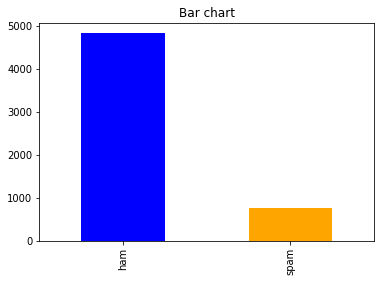

In [8]:
count_Class=pd.value_counts(data["label"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

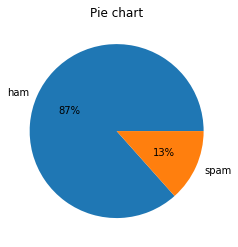

In [9]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

In [ ]:
count1 = Counter(" ".join(data[data['label']=='ham']["data"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['label']=='spam']["data"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

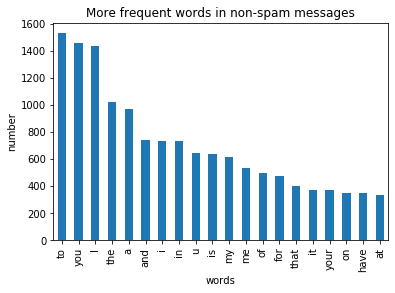

In [11]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

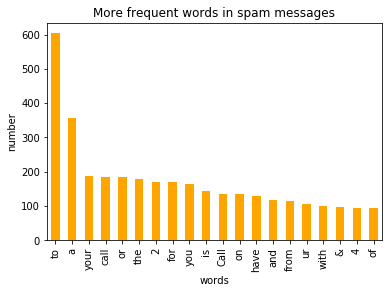

In [12]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [13]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["data"])
np.shape(X)

(5572, 8404)

In [14]:
data["label"]=data["label"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['label'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


In [ ]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 


In [16]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998661,0.974443,0.920635,0.895753
1,0.11001,0.997857,0.976074,0.936508,0.893939
2,0.22001,0.997857,0.977162,0.936508,0.900763
3,0.33001,0.997589,0.977162,0.936508,0.900763
4,0.44001,0.997053,0.977162,0.936508,0.900763
5,0.55001,0.996250,0.976618,0.936508,0.897338
6,0.66001,0.996518,0.976074,0.932540,0.896947
7,0.77001,0.996518,0.976074,0.924603,0.903101
8,0.88001,0.996250,0.976074,0.924603,0.903101
9,0.99001,0.995982,0.976074,0.920635,0.906250


In [17]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

In [18]:
models[models['Test Precision']>=0.8].head(n=5)


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998661,0.974443,0.920635,0.895753
1,0.11001,0.997857,0.976074,0.936508,0.893939
2,0.22001,0.997857,0.977162,0.936508,0.900763
3,0.33001,0.997589,0.977162,0.936508,0.900763
4,0.44001,0.997053,0.977162,0.936508,0.900763


In [19]:
best_index = models[models['Test Precision']>=0.8]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             1.980010
Train Accuracy    0.994107
Test Accuracy     0.982055
Test Recall       0.920635
Test Precision    0.946939
Name: 18, dtype: float64

In [20]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1574,13
Actual 1,20,232


In [21]:
from sklearn.externals import joblib
joblib.dump(bayes, 'bayes.pkl')

['bayes.pkl']

In [ ]:
list_C = np.arange(500, 2000, 100) #100000
score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1 

In [23]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.994910,0.982599,0.873016,1.0
1,600.0,0.995982,0.982599,0.873016,1.0
2,700.0,0.996785,0.982599,0.873016,1.0
3,800.0,0.997053,0.983143,0.876984,1.0
4,900.0,0.997589,0.983143,0.876984,1.0
5,1000.0,0.998125,0.983143,0.876984,1.0
6,1100.0,0.998928,0.983143,0.876984,1.0
7,1200.0,0.999732,0.983143,0.876984,1.0
8,1300.0,1.000000,0.983143,0.876984,1.0
9,1400.0,1.000000,0.983143,0.876984,1.0


In [24]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

C                 500.000000
Train Accuracy      0.994910
Test Accuracy       0.982599
Test Recall         0.873016
Test Precision      1.000000
Name: 0, dtype: float64

In [25]:
models[models['Test Precision']>=0.8].head(n=5)

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.994910,0.982599,0.873016,1.0
1,600.0,0.995982,0.982599,0.873016,1.0
2,700.0,0.996785,0.982599,0.873016,1.0
3,800.0,0.997053,0.983143,0.876984,1.0
4,900.0,0.997589,0.983143,0.876984,1.0


In [26]:
best_index = models[models['Test Precision']>=0.8]['Test Accuracy'].idxmax()
svc = svm.SVC(C=list_C[best_index])
svc.fit(X_train, y_train)
models.iloc[best_index, :]

C                 800.000000
Train Accuracy      0.997053
Test Accuracy       0.983143
Test Recall         0.876984
Test Precision      1.000000
Name: 3, dtype: float64


Confusion matrix with support vector machine classifier.

In [27]:
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,31,221


In [28]:
svc.predict(X_test)

array([0, 0, 0, ..., 0, 0, 1])

In [29]:
joblib.dump(svc, 'svc.pkl')

['svc.pkl']

# Inference both saved model 

In [ ]:
# Inference the saved mode and predict the text spam or not spam
text = "URGENT! You have won a 1 week FREE Prize Jackpot! Txt the IM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"
exa = [text]

text1 ="I HAVE A DATE ON tuesday WITH WILL!!"
exa1 = [text1]

In [ ]:
spam_model1 = open('bayes.pkl','rb')
bayes_from_pickle = joblib.load(spam_model1)

In [32]:
text_vector = f.transform(exa)
result = bayes_from_pickle.predict(text_vector)
if result == 1:
    print("The is spam")
else :
    print("not spam")

The is spam


In [33]:
text_vector = f.transform(exa1)
result = bayes_from_pickle.predict(text_vector)
if result == 1:
    print("The mail is spam")
else :
    print("not spam")

not spam


In [ ]:
spam_model2 = open('svc.pkl','rb')
svc_from_pickle = joblib.load(spam_model2)

In [36]:
text_vector = f.transform(exa)
result = svc_from_pickle.predict(text_vector)
if result == 1:
    print("This is spam")
else :
    print("not spam")

This is spam


In [38]:
text_vector = f.transform(exa1)
result = svc_from_pickle.predict(text_vector)
if result == 1:
    print("This is spam")
else :
    print("not spam")

not spam
